# CNN Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import dict_util as du
import plot_util as pu
import file_util as fu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os

Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
# DATA_DIR = "dataset/feature_files"
DATA_FILE = "amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
MODEL_NAME = "CNN"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{FEATURE_COLUMN}"
MODEL_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"2019-06-18-NN_notebook_protype-report.csv"
TOKENIZER_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [3]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")
df = pd.read_csv(f"{DATA_FILE}")

In [5]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [7]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(112043,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [11]:
train_sequences[:2]

[[20,
  24,
  16,
  11,
  1,
  21,
  2629,
  398,
  710,
  67,
  341,
  30,
  2290,
  153,
  140,
  13,
  1,
  28,
  186,
  396,
  20,
  16,
  93,
  370,
  1346,
  408,
  992],
 [99, 70, 31, 1, 168, 44, 1744, 452]]

In [12]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[9,
  608,
  2584,
  670,
  437,
  246,
  2,
  323,
  5,
  31,
  203,
  340,
  1414,
  643,
  342,
  147,
  242,
  272,
  54,
  128,
  278,
  908,
  27],
 [764,
  1621,
  4,
  783,
  2,
  11,
  1,
  149,
  260,
  3,
  914,
  243,
  249,
  2369,
  2,
  9,
  105,
  11,
  3,
  131,
  94,
  128,
  10,
  21]]

In [13]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=40788
Number of Documents=84032


**Sequence Normalization**

Figure out max length of review and pad the rest so they are all the same length

In [14]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [15]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


In [16]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.95]).values[0])
MAX_SEQUENCE_LENGTH

84

Looks like 95% of our reviews have 64 words or less. If we keep our sequence length to around 64 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [18]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   20,   24,   16,   11,    1,   21, 2629,  398,  710,
          67,  341,   30, 2290,  153,  140,   13,    1,   28,  186,  396,
          20,   16,   93,  370, 1346,  408,  992],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

In [19]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [0]:
EMBED_SIZE = 32
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [21]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0623 04:19:30.069481 140326825625472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 04:19:30.074550 140326825625472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 04:19:30.078145 140326825625472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 04:19:30.114000 140326825625472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0623 04:19:30.152615 140326825625472 deprecation_wrapp

In [22]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 32)            1305248   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 84, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               336250    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total params: 1,645,857
Trainable params: 1,645,857
Non-trainable params: 0
_________________________________________________________________


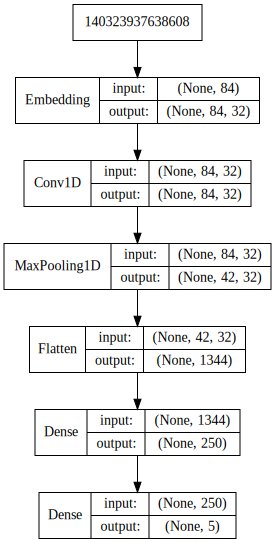

In [23]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0623 04:19:30.366880 140326825625472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0623 04:19:30.445773 140326825625472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 6s 83us/step - loss: 0.9798 - acc: 0.6240 - val_loss: 0.8719 - val_acc: 0.6617
Epoch 2/50
67225/67225 [==============================] - 3s 39us/step - loss: 0.7753 - acc: 0.6953 - val_loss: 0.8584 - val_acc: 0.6680
Epoch 3/50
67225/67225 [==============================] - 3s 39us/step - loss: 0.6618 - acc: 0.7412 - val_loss: 0.9045 - val_acc: 0.6579
Epoch 4/50
67225/67225 [==============================] - 3s 40us/step - loss: 0.5544 - acc: 0.7887 - val_loss: 1.0116 - val_acc: 0.6551
Epoch 00004: early stopping


In [25]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


28011/28011 [==============================] - 1s 46us/step
Accuracy: 65.63%


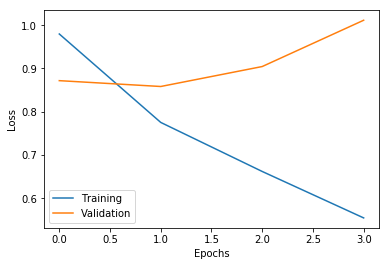

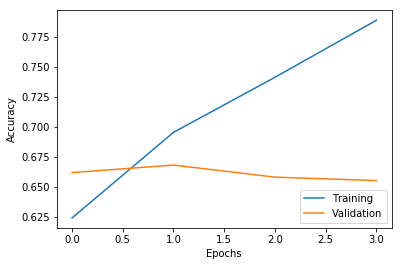

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [0]:
y_predict = model.predict(X_test)

In [28]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,0.000004,0.000052,0.001197,0.055622,0.943124
1,0.015169,0.050951,0.205766,0.348837,0.379277
2,0.000052,0.000152,0.001693,0.055524,0.942579
3,0.092361,0.064074,0.044521,0.047371,0.751673
4,0.000266,0.000348,0.005377,0.085862,0.908147


In [0]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [0]:
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]

In [31]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[ 2904,   441,   228,    55,   340],
       [  744,   375,   327,   117,   308],
       [  427,   348,   635,   373,   748],
       [  132,   148,   506,  1015,  2951],
       [  211,   110,   256,   856, 13456]])

In [32]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.66      0.73      0.69      3968
           2       0.26      0.20      0.23      1871
           3       0.33      0.25      0.28      2531
           4       0.42      0.21      0.28      4752
           5       0.76      0.90      0.82     14889

    accuracy                           0.66     28011
   macro avg       0.48      0.46      0.46     28011
weighted avg       0.61      0.66      0.62     28011



In [0]:
model.save(MODEL_FILE)

# Save off various files

In [0]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [0]:
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["embedding"] = "bow"
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = X_test.shape[0]
flattened["test_features"] = X_test.shape[1]
flattened["train_examples"] = X_train.shape[0]
flattened["train_features"] = X_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [38]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head()



,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,confusion_matrix,description,embedding,file,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.675135,0.609566,0.756511,1651.0,0.147748,0.273333,0.101235,810.0,0.238674,0.267658,0.215354,1003.0,0.314011,0.348416,0.285790,1886.0,0.839232,0.804412,0.877203,7150.0,0.668640,[[1249 95 120 57 130]\n [ 376 82 156 ...,amazon_reviews_us_Wireless_v1_00-preprocessed-...,bow,amazon_reviews_us_Wireless_v1_00-preprocessed-...,0.442960,0.460677,0.447219,12500.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,CNN,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,success,2019-06-23 04:04:55,12500.0,65.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,37500.0,65.0,0.645316,0.632393,0.668640,12500.0
1,0.692583,0.657311,0.731855,3968.0,0.227756,0.263713,0.200428,1871.0,0.283292,0.325307,0.250889,2531.0,0.283203,0.420116,0.213594,4752.0,0.823198,0.755828,0.903754,14889.0,0.656349,"[[2904, 441, 228, 55, 340], [744, 375, 327, 11...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,bow,amazon_reviews_us_Wireless_v1_00-preprocessed-...,0.462007,0.484455,0.460104,28011.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,CNN,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,success,2019-06-23 04:20:19,28011.0,84.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,84032.0,84.0,0.624529,0.613148,0.656349,28011.0


In [0]:
report_df.to_csv(REPORT_FILE, index=False)